# Rayleigh-Taylor Instability

We will represent an incompressible, viscous, diffusive, Boussinesq fluid to simulate a Rayleigh-Taylor instability. 

<img src="./Rayleigh-Taylor.jpeg" width="600" height="300" />

This exercise was designed for the course Waves and Instabilities in Geophysical Fluid Dynamics of the Master's Degree in Advanced Physics and Applied Mathematics, at University of the Balearic Islands (Spain).

Author: Daniel Argüeso
Email: d.argueso@uib.es

Feb-2023

## Import modules

In [58]:
import numpy as np
from dedalus import public as de
from dedalus.extras import flow_tools
import matplotlib.pyplot as plt
import h5py
import time

## Import and set logging

In [59]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
logger = logging.getLogger(__name__)

## Define the problem

### Set problem domain

You need to define the domain of the problem. The first two items indicate the aspect ratio. For exmaple (2,1). The second one indicates the number of grid points in each direction. They should be consistent with the aspect ratio

In [60]:
Lx, Ly = (2., 1.)
nx, ny = (512, 256)

### Create bases and domain

They basically define the transformation between the grid space and the spectral space. There are various types of basis, but the most popular are:
- Fourier: to define periodic functions in an intervarl (usually the direction of the flow)
- Chebyshev: general functions in an interval (they require boundary conditions, usually top and bottom)

For each basis we specify the direction, the dimensions, the interval and the dealising. Dealising is used to evaluate operators in the Fourier space and for numerical stability. We use the default 3/2.

Then, the domain, which combines both bases and the dimensions above to define the problem domain

In [61]:
x_basis = de.Fourier('x', nx, interval = (0,Lx), dealias =3/2) 
y_basis = de.Chebyshev('y', ny, interval=(-Ly/2, Ly/2), dealias=3/2) #You must set boundary conditions with Chebyshev. Do not change dealias.
domain = de.Domain([x_basis,y_basis], grid_dtype=np.float64)

### Set parameters

This is optional, but it is a good practice to define parameters that will then be used in the equations. We will need to assign to dedalus parameters within our problem later on, as we will see.

In [62]:
Reynolds = 3e2
Schmidt = 1e2
g = 9.81

### Define the problem and the equations

We define the problem. We have different options, but we will use Initial value problem (IVP) in all of our exercises.
When we define the problem, we have to specify the domain, the variables, the parameters and the equations.

In the first command, we take the domain specifications we defined before and we define the variables that the problem will use. Here, for example we have pressure, horizontal and vertical velocities, and density. On top of that we also have vertical derivatives of density, and velocities, which we will need to specify the equations.

In [63]:
#IVP: Initial value problem. uy, vy and rhoy are the partial derivatives of those variables.
problem = de.IVP(domain, variables = ['p','u','uy','v','vy','rho','rhoy']) 

Next, we define the parameters in the problem's framework, so that they can be used in the equations

In [64]:
problem.parameters['Re'] = Reynolds
problem.parameters['Sc'] = Schmidt 
problem.parameters['g'] = g

Now we move on to solving the problem. We need have a crear idea of what the equations of the problem will be, and then write them in dedalus notation.

These are the problem equations for the Rayleigh-Taylor instability:

$$ \partial_t u + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} u + \frac{\partial_x p}{\rho_0} =  \frac{1}{{\rm Re}} \nabla^2 u $$
$$ \partial_t v + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} v + \frac{\partial_y p}{\rho_0} + \frac{\rho g}{\rho_0} =  \frac{1}{{\rm Re}} \nabla^2 v $$
$$ \boldsymbol{\nabla}\boldsymbol{\cdot}\boldsymbol{u} = 0 $$
$$ \partial_t \rho + \boldsymbol{u}\boldsymbol{\cdot}\boldsymbol{\nabla} \rho = \frac{1}{{\rm ReSc}} \nabla^2 \rho $$

In [65]:
#Equations cannot have no-linear terms (two partial derivatives) on the rhs so we need to define a variable uy beforehand
# All no-linear terms must go on the lhs.
# An important step in programming the equations is to define what goes on each side.
# Use these as reference to build upon.

problem.add_equation("dt(u) + dx(p) - 1/Re*(dx(dx(u)) + dy(uy)) = - u*dx(u) - v*dy(u)") 
problem.add_equation("dt(v) + dy(p) - 1/Re*(dx(dx(v)) + dy(vy)) + g*rho = -u*dx(v) - v*vy")
problem.add_equation("dx(u) + vy = 0")
problem.add_equation("dt(rho) - 1/(Re*Sc)*(dx(dx(rho)) + dy(rhoy)) = -u*dx(rho) - v*rhoy")


In [66]:
# These are the definitions of the variables that replace  partial derivatives to avoid non-linear terms on the rhs.

problem.add_equation("vy - dy(v) = 0")
problem.add_equation("uy - dy(u) = 0")
problem.add_equation("rhoy - dy(rho) = 0")

### Define the boundary conditions

As a general rule, for every derivate on y (our special dimension, Chebyshev), we need to add one boundary conditions. 
One of them is the pressure gauge.

In [67]:
problem.add_bc("left(u) = 0")
problem.add_bc("right(u) = 0")
problem.add_bc("left(v) = 0")
problem.add_bc("right(v) = 0", condition="(nx != 0)")
problem.add_bc("integ(p,'y') = 0", condition="(nx == 0)")
problem.add_bc("left(rho) = -0.1") #left down
problem.add_bc("right(rho) = 0.1") #right up

# We need to choose the boundary conditions, which will make the problem stable or not.
# This is the second challenge in defining the problem.
# Remember that the right and left edges of the domain were defined using Fourier, which means they are periodic and thus what exits through one edge comes in through the opposite edge.


## Define the solver

### Timestepping

We have different numerical schemes we can choose from. In our examples, we will use the RK443, but feel free to try others. You may read the documentation to see the full range of options.

In [68]:
ts = de.timesteppers.RK443

### Building the solver

Here we simply initialize the solver.

In [69]:
solver =  problem.build_solver(ts)

x = domain.grid(0)
y = domain.grid(1)
u = solver.state['u']
uy = solver.state['uy']
v = solver.state['v']
vy = solver.state['vy']
p = solver.state['p']
rho = solver.state['rho']
rhoy = solver.state['rhoy']

2024-01-16 12:18:26,866 pencil 0/1 INFO :: Building pencil matrix 1/256 (~0%) Elapsed: 0s, Remaining: 6s, Rate: 4.1e+01/s
2024-01-16 12:18:27,282 pencil 0/1 INFO :: Building pencil matrix 26/256 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 5.9e+01/s
2024-01-16 12:18:27,696 pencil 0/1 INFO :: Building pencil matrix 52/256 (~20%) Elapsed: 1s, Remaining: 3s, Rate: 6.1e+01/s
2024-01-16 12:18:28,108 pencil 0/1 INFO :: Building pencil matrix 78/256 (~30%) Elapsed: 1s, Remaining: 3s, Rate: 6.2e+01/s
2024-01-16 12:18:28,521 pencil 0/1 INFO :: Building pencil matrix 104/256 (~41%) Elapsed: 2s, Remaining: 2s, Rate: 6.2e+01/s
2024-01-16 12:18:28,937 pencil 0/1 INFO :: Building pencil matrix 130/256 (~51%) Elapsed: 2s, Remaining: 2s, Rate: 6.2e+01/s
2024-01-16 12:18:29,351 pencil 0/1 INFO :: Building pencil matrix 156/256 (~61%) Elapsed: 3s, Remaining: 2s, Rate: 6.2e+01/s
2024-01-16 12:18:29,761 pencil 0/1 INFO :: Building pencil matrix 182/256 (~71%) Elapsed: 3s, Remaining: 1s, Rate: 6.2e+01/s
2024-0

Set the solver parameters

Here we define some paramters, to help stop the simulation. In our case, we define the maximum duration, but we can define others.

In [70]:
solver.stop_sim_time = 10.01
solver.stop_wall_time = np.inf
solver.stop_iteration = np.inf

Set initial timestep and CFL conditions

We set the initial timestep, which will be later modified to ensure stability and optimize the simulation depending on the problem itself. We can also define cfl conditions based on velocities.

In [71]:
# If the problem is unstable in the first step, we need to set a smaller timestep.
# If the problem si completely stable, the time step will grow indefinitely.
initial_dt = 0.05*Lx/nx 
cfl = flow_tools.CFL(solver,initial_dt,safety=0.5,threshold=0.05)
cfl.add_velocities(('u','v'))

### Initial conditions

Once the problem and the solver are set, we need to describe the initial conditions. These are critical to the problem and may be the difference between success and failure. A right choice of the initial conditions will produce the instability we are studying or simply make the model crash.

Create array with noise for initial conditions

In [72]:
# Initial conditions must include some noise to nudge the system to instabilities can grow. Otherwise, the system will be in a unstable equilibrium.
gshape = domain.dist.grid_layout.global_shape(scales=1)
slices = domain.dist.grid_layout.slices(scales=1)
rand = np.random.RandomState(seed=42)
noise = rand.standard_normal(gshape)[slices] 

Set the initial conditions for velocity and density

In [73]:
a = 0.02
amp = -0.2
sigma = 0.2
flow = -1.0
u['g'] = 0
rho['g'] = 0.1*np.tanh(2*y/a) # hyperbolic tangent function
v['g'] = noise / 40

## Solving

In this step run the solver. At the same time we save some information for analysis we may want to make later on. And draw the plots every certain number of timesteps. Saving the analysis is not necessary, but it may be helpful to modify plots without having to run the entire simulation again.

Prepare the variables that will be saved for analysis (this is optional)

In [74]:
# This way we can save variables so that the plot can be redone after. 
analysis = solver.evaluator.add_file_handler('analysis', sim_dt=0.1, max_writes=1000)
analysis.add_task('rho')


### Plotting initial state

Make the plot for the initial state

### Move into solving loop

2024-01-16 12:18:31,315 __main__ 0/1 INFO :: Starting loop
2024-01-16 16:08:10,769 solvers 0/1 INFO :: Simulation stop time reached.


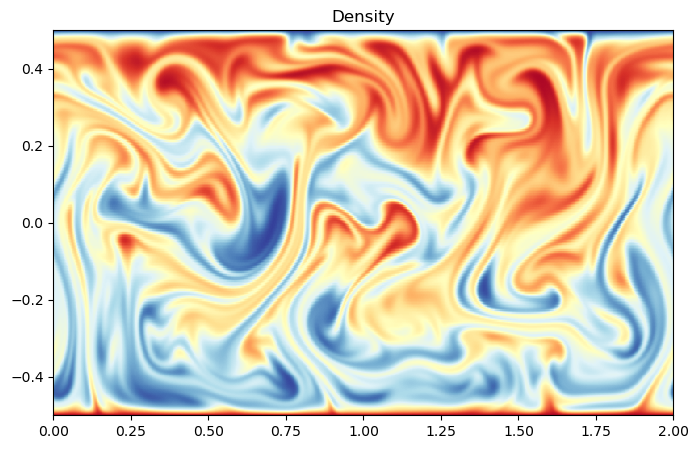

In [75]:
# Drawing inital state
x = domain.grid(0,scales=domain.dealias) 
y = domain.grid(1,scales=domain.dealias)
xm, ym = np.meshgrid(x,y)
fig, axis = plt.subplots(figsize=(8,5))
rho.set_scales(domain.dealias)
p = axis.pcolormesh(xm, ym, rho['g'].T, cmap='RdYlBu')
axis.set_title('Density')
axis.set_xlim([0,2.])
axis.set_ylim([-0.5,0.5])
plt.savefig(f'./Rayleigh-Taylor_000.png')
logger.info('Starting loop')
start_time = time.time()
nt=1
while solver.ok:
    dt = cfl.compute_dt() 
    solver.step(dt)
    # We make a plot every certain number of timesteps, not for all
    if solver.iteration % 5 == 0:
        p.set_array(rho['g'].T)
        axis.set_title('Density')
        fig.canvas.draw()
        plt.savefig(f'./Rayleigh-Taylor_{nt:03d}.png')
        nt+=1

### ending program with information

In [76]:
end_time = time.time()
logger.info('Run time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %solver.iteration)

2024-01-16 16:08:10,999 __main__ 0/1 INFO :: Run time: 13779.683683
2024-01-16 16:08:11,001 __main__ 0/1 INFO :: Iterations: 3932
